# Flight delays and Cancellation Exploratory Data Analysis

A dataset of national flights inside the USA in 2021 is cleaned, joined and analyzed. Visualizations are built to identify trends in data and obtain insights about cancellations and delays. The following questions will be answered:

1. Why were flights canceled?

2. How likely the cancellation of a flight after a long delay?

3. What are the main reasons for flight delays?

4. Which airiline has the most delays?

5. In which airports flights are being delayed the most due to weather conditions?

In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.basemap import Basemap

## Data extraction

Sources: 
* [Flight and airlines information](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022)

* [Cancellation codes](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=f2rpvsvr5%FDgur%FDern510%FDS14%FDPn0pryyn6v10&Svryq_gB2r=Pun4&Y11x72_gnoyr=Y_PNaPRYYNgVba&gnoyr_VQ=FGK&flf_gnoyr_anzr=g_bagVZR_ZNeXRgVaT&fB5_Svryq_anzr=PNaPRYYNgVba_PbQR)

* [USA airports geographical location](https://www.kaggle.com/datasets/nancyalaswad90/us-airports)




In [3]:
#Flights data
flights_data = [pd.read_csv(filename, dtype = str) for filename in glob.glob("data/flights/*.csv")]
df_flights_raw = pd.concat(flights_data, axis=0)

#additional dimensions
df_cancellation_codes = pd.read_csv("data/dimensions/cancellation_code.csv")
df_airlines = pd.read_csv("data/dimensions/airlines.csv")
df_airports = pd.read_csv("data/dimensions/airports.csv")

In [4]:
df_flights_raw.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,2021,1,1,2,6,2021-01-02,DL,DL_CODESHARE,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2021,1,1,3,7,2021-01-03,DL,DL_CODESHARE,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2021,1,1,4,1,2021-01-04,DL,DL_CODESHARE,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2021,1,1,7,4,2021-01-07,DL,DL_CODESHARE,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2021,1,1,8,5,2021-01-08,DL,DL_CODESHARE,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


## Data Preparation


In [5]:
#Drop columns with all nulls
df_flights_raw.dropna(axis = 1, how = 'all', inplace=True)

In [6]:
#Keep only columns we're interested in
columns_to_keep = ['Month','FlightDate','IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline','Origin','Dest','CRSDepTime','DepTime','DepDelay','DepDelayMinutes','DepDel15','DepartureDelayGroups','DepTimeBlk','CRSArrTime','ArrTime','ArrDelay','ArrDelayMinutes','ArrDel15','ArrivalDelayGroups','Cancelled','CancellationCode','Flights','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df_flights = df_flights_raw[columns_to_keep]

In [7]:
#rename columns to have a single naming convention
new_column_names = {
    'Month': 'month',
    'FlightDate':  'flight_date',
    'IATA_Code_Marketing_Airline': 'marketing_airline_code',
    'IATA_Code_Operating_Airline': 'operating_airline_code',
    'Origin': 'origin_airport',
    'OriginCityName': 'origin_city',
    'Dest': 'destination_airport',
    'CRSDepTime': 'scheduled_departure_time',
    'DepTime': 'departure_time',
    'DepDelay': 'dep_time_difference',
    'DepDelayMinutes': 'dep_delay_time',
    'DepDel15': 'dep_delay_over_15_min',
    'DepartureDelayGroups': 'dep_delay_group',
    'DepTimeBlk': 'dep_time_bulk',
    'CRSArrTime': 'scheduled_arrival_time',
    'ArrTime': 'arrival_time',
    'ArrDelay': 'arr_time_difference',
    'ArrDelayMinutes': 'arr_delay_time_',
    'ArrDel15': 'arr_delay_over_15_min',
    'ArrivalDelayGroups': 'arr_delay_group',
    'Cancelled': 'canceled',
    'CancellationCode': 'cancellation_code',
    'Flights': 'flights',
    'CarrierDelay': 'carrier_delay_time',
    'WeatherDelay': 'weather_delay_time',
    'NASDelay': 'nas_delay_time',
    'SecurityDelay': 'security_delay_time',
    'LateAircraftDelay': 'late_aircraft_delay_time'
}

df_flights = df_flights.rename(columns = new_column_names)

In [8]:
#Convert to numeric if applies
df_flights = df_flights.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

#convert flightDate to datetime
df_flights['flight_date']= pd.to_datetime(df_flights['flight_date'])

#convert to boolean
df_flights['canceled'] = df_flights['canceled'].astype(bool)
df_flights['dep_delay_over_15_min'] = df_flights['dep_delay_over_15_min'].astype(bool)
df_flights['arr_delay_over_15_min'] = df_flights['arr_delay_over_15_min'].astype(bool)


In [9]:
df_flights.head()

,month,flight_date,marketing_airline_code,operating_airline_code,origin_airport,destination_airport,scheduled_departure_time,departure_time,dep_time_difference,dep_delay_time,...,arr_delay_over_15_min,arr_delay_group,canceled,cancellation_code,flights,carrier_delay_time,weather_delay_time,nas_delay_time,security_delay_time,late_aircraft_delay_time
0,1,2021-01-02,DL,9E,CVG,BOS,730,733.0,3.0,3.0,...,False,-1.0,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,1,2021-01-03,DL,9E,CVG,BOS,730,727.0,-3.0,0.0,...,False,-1.0,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,1,2021-01-04,DL,9E,CVG,BOS,730,737.0,7.0,7.0,...,False,-1.0,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,1,2021-01-07,DL,9E,CVG,BOS,1715,1710.0,-5.0,0.0,...,False,-1.0,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,1,2021-01-08,DL,9E,CVG,BOS,1715,1711.0,-4.0,0.0,...,False,0.0,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [10]:
#rename to fit naming convention

df_cancellation_codes.rename( columns = {'Code': 'cancellation_code', 'Description': 'cancellation_reason'}, inplace = True)

#set index for joins
df_cancellation_codes.set_index('cancellation_code', inplace = True)

In [11]:
df_cancellation_codes

,cancellation_reason
cancellation_code,
A,Carrier
B,Weather
C,National Air System
D,Security


In [12]:
#rename to fit naming convention

airport_columns = {
    'iata' : 'airport_code',
    'airport' : 'airport_name',
    'city': 'city',
    'country': 'country',
    'lat': 'latitude',
    'long': 'longitude',
}
df_airports.rename(columns = airport_columns, inplace= True)

#set index for joins
df_airports.set_index('airport_code', inplace = True)
df_airports.head()

,airport_name,city,state,country,latitude,longitude
airport_code,,,,,,
00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [13]:
#rename to fit naming convention
df_airlines.rename(columns = {'Code': 'airline_code', 'Description': 'airline_name'}, inplace= True)

#set index for joins
df_airlines.set_index('airline_code', inplace = True)
df_airlines.head()

,airline_name
airline_code,
02Q,Titan Airways
04Q,Tradewind Aviation
05Q,"Comlux Aviation, AG"
06Q,Master Top Linhas Aereas Ltd.
07Q,Flair Airlines Ltd.


## Analysis

In [23]:
#Color Palette for graphs

colors = ['#F16767','#FF9B6A','#F1F27E','#BA94D1', '#94A3D1']

In [24]:
# create boolean column for delayed flights

df_flights['delayed'] = [True if x > 0 else False for x in df_flights['dep_delay_time']]

In [25]:
#Total number of scheduled, delayed and canceled flights
df_flights[['flights','delayed','canceled']].sum()

flights     6311871.0
delayed     2055690.0
canceled     111018.0
dtype: float64

In [26]:
total_flights = df_flights['flights'].sum()
total_delayed_percent = (df_flights['delayed'].sum() / df_flights['flights'].sum())*100
total_canceled_percent = (df_flights['canceled'].sum() / df_flights['flights'].sum())*100

print('There were ' + str(total_flights) + ' local flights scheduled in the USA in 2021, ' + str(total_delayed_percent)+ '% were delayed and ' + str(total_canceled_percent)+ '% were canceled.' )

There were 6311871.0 local flights scheduled in the USA in 2021, 32.56863139313209% were delayed and 1.7588762507979014% were canceled.


## Business Questions

### 1. What are the main reasons for a flight to be canceled?


In [27]:
#Join to get number of canceled flights per reason

df_canceled_flights = df_flights[df_flights['canceled'] == True].join(df_cancellation_codes, on = 'cancellation_code')
cancel_reasons = df_canceled_flights.groupby(['cancellation_reason']).size().sort_values(ascending=False)

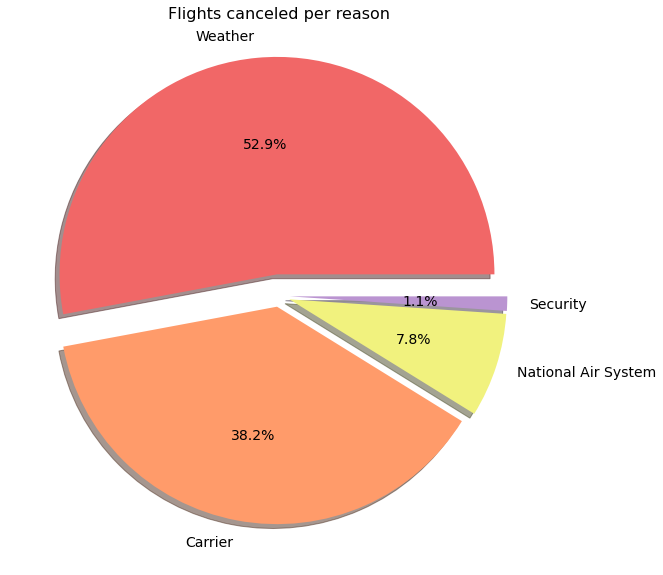

In [28]:
# Create pie chart
exp = (0.1, 0.05, 0.05, 0.05)
fig_cancel_reason, ax_cancel_reason = plt.subplots(figsize = (10,10))
ax_cancel_reason.pie(cancel_reasons, labels=list(cancel_reasons.index), autopct='%1.1f%%', colors = colors,textprops={'fontsize': 14}, explode=exp, shadow="True")
plt.title('Flights canceled per reason', fontsize = 16)
fig_cancel_reason.set_facecolor('white')

plt.savefig("graphs/cancellation_reasons.png")
plt.show()

### 2. How likely is a flight to be canceled after a long delay?

In [29]:

#Creating buckets of 15min for the delay time 

df_flights['dep_delay_group'] = df_flights['dep_delay_group'].replace(np.nan,-1000)
df_flights['dep_bucket_start'] = df_flights['dep_delay_group'] *15
df_flights['dep_bucket_start'] = df_flights['dep_bucket_start'].apply(int).apply(str)
df_flights['dep_bucket_start'] =df_flights['dep_bucket_start'] .replace('-15000',np.nan)

df_flights['dep_bucket_end'] = df_flights['dep_delay_group'] *15 +15
df_flights['dep_bucket_end'] = df_flights['dep_bucket_end'].apply(int).apply(str)
df_flights['dep_bucket_end'] =df_flights['dep_bucket_end'] .replace('-15000',np.nan)

df_flights['dep_delay_group'] = df_flights['dep_delay_group'].replace(-1000,np.nan)
df_flights['dep_delay_bucket'] = df_flights['dep_bucket_start'] +" to "+ df_flights['dep_bucket_end'] + ' min'

df_flights.drop(['dep_bucket_start','dep_bucket_end'], axis = 1, inplace =True)



In [30]:
# get % of delayed flights that were canceled per delay time bucket
df_delayed_canceled = df_flights[['dep_delay_group','dep_delay_bucket', 'flights', 'canceled']]
df_delayed_canceled = df_delayed_canceled.groupby(['dep_delay_group','dep_delay_bucket',]).sum()

df_delayed_canceled = df_delayed_canceled.droplevel('dep_delay_group')
df_delayed_canceled['canceled_percent'] = (df_delayed_canceled['canceled'] / df_delayed_canceled['flights']) *100

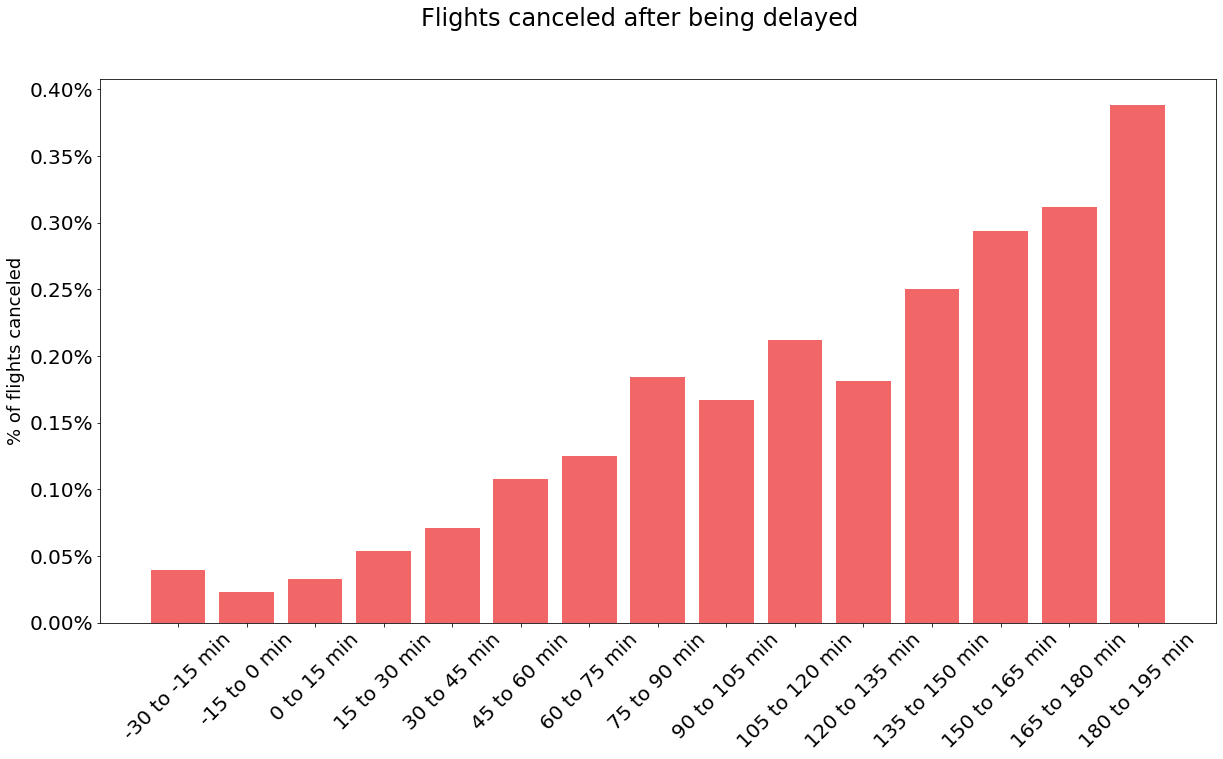

In [31]:
#create distribution graph

delay_time_buckets = list(df_delayed_canceled.index)
canceled_percent = df_delayed_canceled['canceled_percent'].values

fig_delayed_canceled, ax_delayed_canceled = plt.subplots(figsize=(20, 10))
delayed_canceled_bar = ax_delayed_canceled.bar(delay_time_buckets,canceled_percent, color = colors[0])

ax_delayed_canceled.set_ylabel('% of flights canceled', fontsize = 18)
ax_delayed_canceled.tick_params(axis='y', labelsize=20)
ax_delayed_canceled.tick_params(axis='x', labelsize=20, labelrotation = 45)
ax_delayed_canceled.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))


fig_delayed_canceled.suptitle('Flights canceled after being delayed', fontsize = 24)

plt.savefig("graphs/delay_cancellations.png")
plt.show()

### 3. What are the main reasons for a flight to be delayed?

In [32]:
# create month name column 

df_flights['month_name'] = df_flights['flight_date'].dt.month_name()

# replace 0 with nans so they won't be counted
df_delays = df_flights[['month', 'month_name', 'dep_time_bulk', 'delayed','flights', 'carrier_delay_time','weather_delay_time','nas_delay_time', 'security_delay_time', 'late_aircraft_delay_time']].replace(0,np.nan)



In [33]:
#dataframe with only the delay resons times to group by later
df_delay_reasons = df_delays[['carrier_delay_time','weather_delay_time','nas_delay_time', 'security_delay_time', 'late_aircraft_delay_time']]

# rename delay reasons for plotting purposes
dict_delay_reasons = {'carrier_delay_time': 'Carrier', 'weather_delay_time': 'Weather', 'nas_delay_time': 'National Air System', 'security_delay_time' : 'Security', 'late_aircraft_delay_time': 'Late Aircraft'}
df_delay_reasons = df_delay_reasons.rename(columns= dict_delay_reasons)

#delay time per reason
delay_reasons_minutes = df_delay_reasons.sum(axis = 0)/df_delay_reasons.sum(axis = 0).sum()
delay_reasons_minutes = delay_reasons_minutes.sort_values(ascending=False) * 100
delay_reasons_minutes.name = 'average_delay_time'

#count of delayed flights per reason
delay_reasons_count = df_delay_reasons.count()/df_delay_reasons.count().sum()
delay_reasons_count = delay_reasons_count.sort_values(ascending=False) * 100
delay_reasons_count.name = 'delayed_flights'

#merged dataframe of delay time and flights per reason
delayed_reasons = pd.merge(delay_reasons_count,delay_reasons_minutes, right_index=True, left_index=True)

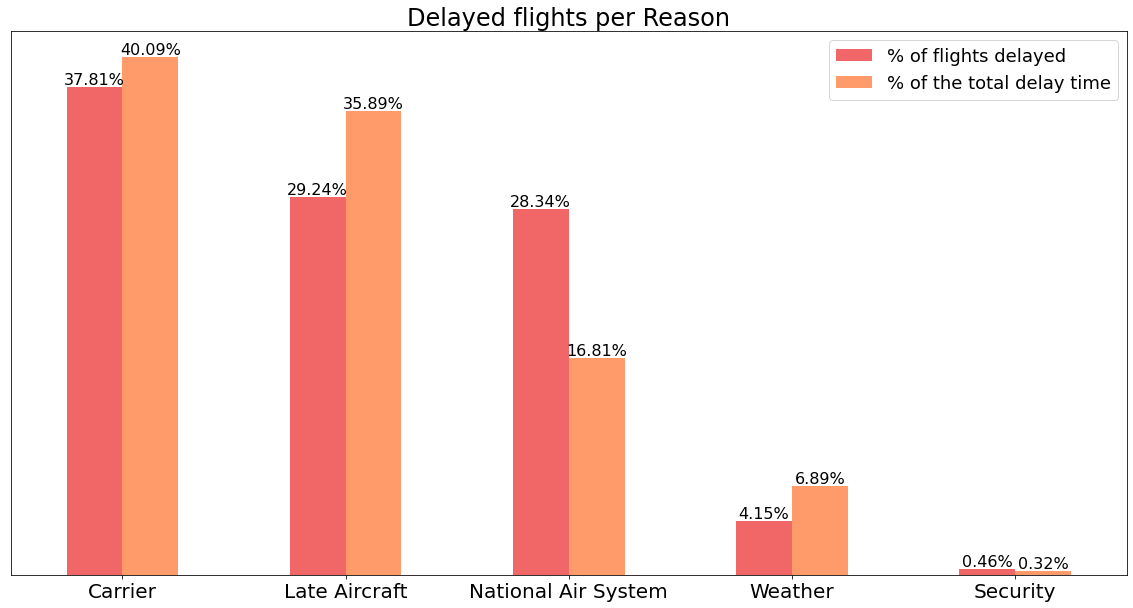

In [34]:
#Plot bar chart 

delay_reasons_bar = delayed_reasons.plot.bar(rot= 0, color = colors[:2], figsize=(20, 10))
plt.xticks(fontsize = 20)
delay_reasons_bar.set(xlabel=None)
delay_reasons_bar.axes.get_yaxis().set_visible(False)
delay_reasons_bar.bar_label(delay_reasons_bar.containers[0], label_type='edge', fmt = '%.2f%%', fontsize = 16)

delay_reasons_bar.bar_label(delay_reasons_bar.containers[1], label_type='edge', fmt = '%.2f%%', fontsize = 16)
delay_reasons_bar.legend(['% of flights delayed', '% of the total delay time'], fontsize = 18)

plt.title('Delayed flights per Reason', fontsize = 24)

plt.savefig("graphs/delay_reasons.png")
plt.show()

In [35]:
# Get delay times per month 

df_monthly_delays = df_delays[['month', 'month_name', 'carrier_delay_time','weather_delay_time','nas_delay_time', 'security_delay_time', 'late_aircraft_delay_time','flights']].groupby(['month', 'month_name']).sum()
df_monthly_delays = df_monthly_delays.rename(columns = dict_delay_reasons)

# Months list for plotting axis
monthly_delays_index = list(df_monthly_delays.index)
month_list = [index[1] for index in monthly_delays_index]

# Delay reasons list for plotting legend
delay_reasons_list = list(df_monthly_delays.columns)

# Getting values to plot
monthly_delays_array = df_monthly_delays.to_numpy().transpose()
delay_times_array = monthly_delays_array[:5] 
flight_volume = monthly_delays_array[5] / 1000

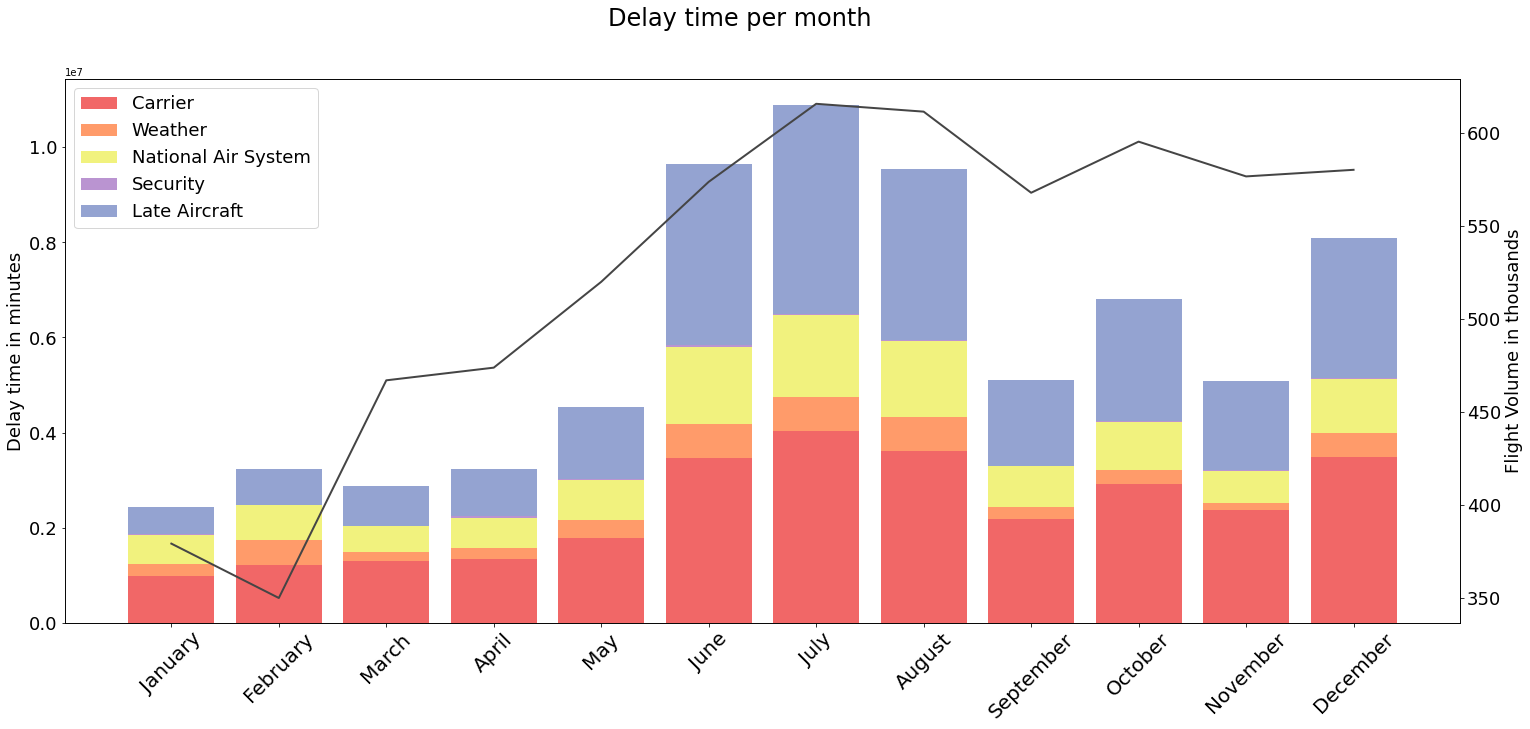

In [36]:
#Plot stacked bar chart for delay reasons and line for volume

fig_delay_monthly, ax_delay_monthly = plt.subplots(figsize=(25, 10))

for i in range(delay_times_array.shape[0]):
  ax_delay_monthly.bar(month_list, delay_times_array[i], color = colors[i], bottom = np.sum(delay_times_array[:i], axis = 0))
 

ax_delay_monthly.legend(labels=delay_reasons_list, fontsize = 18, loc = 'upper left')
ax_delay_monthly.set_ylabel('Delay time in minutes', fontsize = 18)
ax_delay_monthly.tick_params(axis='y', labelsize=18)
ax_delay_monthly.tick_params(axis='x', labelsize=20,labelrotation = 45)
 
ax_volume_monthly = ax_delay_monthly.twinx()

volume_line = ax_volume_monthly.plot(month_list, flight_volume, color ='#454545', linewidth = 2)

ax_volume_monthly.set_ylabel('Flight Volume in thousands', fontsize = 18)
ax_volume_monthly.tick_params(axis='y', labelsize=18)
ax_volume_monthly.ticklabel_format(axis='y', style = 'sci')

fig_delay_monthly.suptitle('Delay time per month', fontsize = 24)

plt.savefig("graphs/delays_monthly.png")
plt.show()

In [37]:
# Get delay times per departure time bucket
df_timebucket_delays = df_delays[['dep_time_bulk', 'carrier_delay_time','weather_delay_time','nas_delay_time', 'security_delay_time', 'late_aircraft_delay_time','flights']].groupby(['dep_time_bulk']).sum()
df_timebucket_delays = df_timebucket_delays.rename(columns = dict_delay_reasons)

# Departure time buckets list for plotting axis
timebucket = list(df_timebucket_delays.index)

# Delay reasons list for plotting legend
delay_reasons_list = list(df_timebucket_delays.columns)

# Getting values to plot
timebucket_delays_array = df_timebucket_delays.to_numpy().transpose()
delay_times_array = timebucket_delays_array[:5] 
flight_volume = timebucket_delays_array[5] / 1000

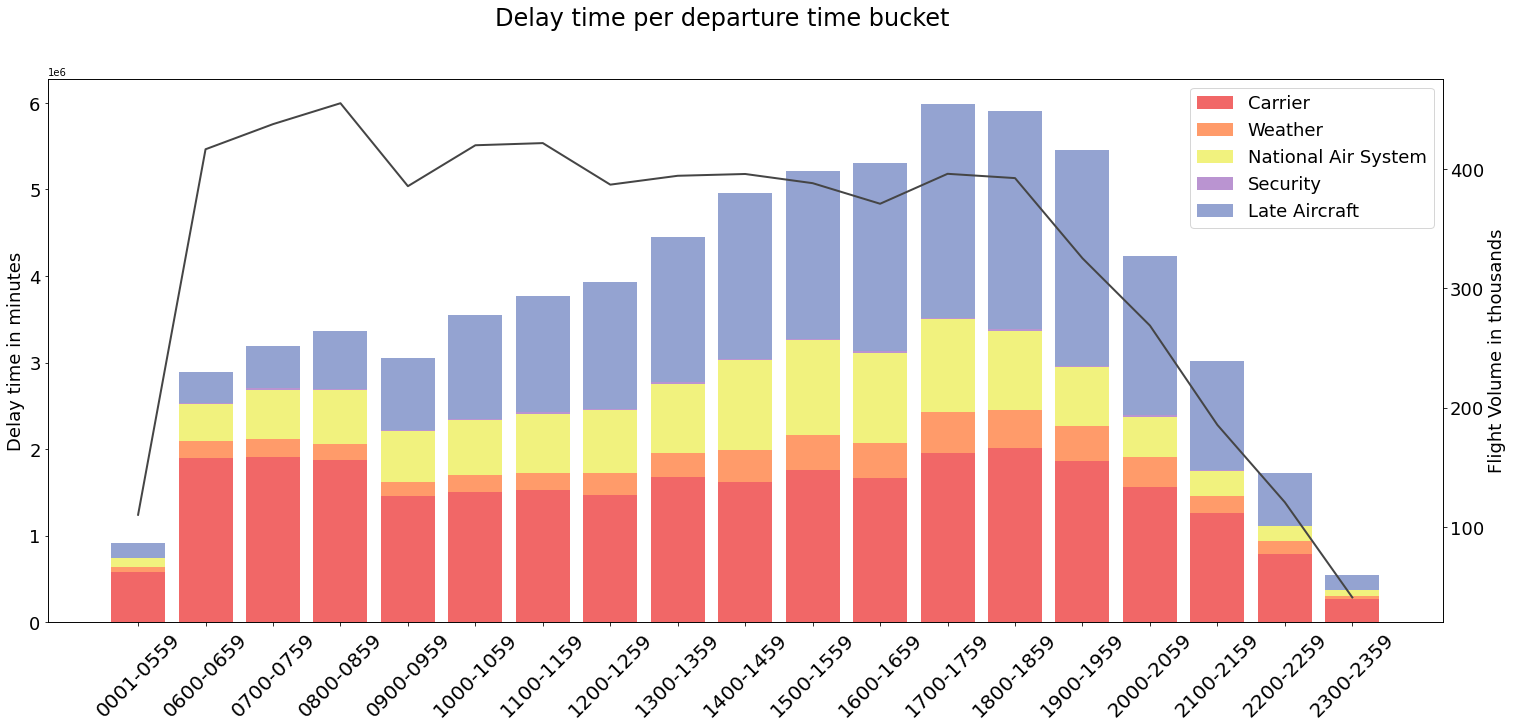

In [38]:
#Plot stacked bar chart for delay reasons and line for volume
fig_delay_timebucket, ax_delay_timebucket = plt.subplots(figsize=(25, 10))

for i in range(delay_times_array.shape[0]):
  ax_delay_timebucket.bar(timebucket, delay_times_array[i], color = colors[i], bottom = np.sum(delay_times_array[:i], axis = 0))
 

ax_delay_timebucket.legend(labels=delay_reasons_list, fontsize = 18, loc = 'upper right')
ax_delay_timebucket.set_ylabel('Delay time in minutes', fontsize = 18)
ax_delay_timebucket.tick_params(axis='y', labelsize=18)
ax_delay_timebucket.tick_params(axis='x', labelsize=20, labelrotation = 45)
 
ax_volume_timebucket = ax_delay_timebucket.twinx()

volume_line = ax_volume_timebucket.plot(timebucket, flight_volume, color ='#454545', linewidth = 2)

ax_volume_timebucket.set_ylabel('Flight Volume in thousands', fontsize = 18)
ax_volume_timebucket.tick_params(axis='y', labelsize=18)
ax_volume_timebucket.ticklabel_format(axis='y', style = 'sci')

fig_delay_timebucket.suptitle('Delay time per departure time bucket', fontsize = 24)

plt.savefig("graphs/delays_buckets.png")
plt.show()

### 4. Which are the TOP 5 airlines with higher cancel and delay rates?

In [39]:
#get delayed flights and delay time per airline
df_flights_airlines = df_flights.join(df_airlines, on = 'marketing_airline_code')
df_marketing_airlines = df_flights_airlines[['airline_name','flights', 'dep_delay_time','delayed']].groupby(['airline_name']).sum()

#renaming as suffix 'airline' is redundant for plotting purposes
df_marketing_airlines.index = [i.split()[0] for i in df_marketing_airlines.index]

#measures
df_marketing_airlines['delayed_percent'] = (df_marketing_airlines['delayed'] / df_marketing_airlines['flights'])*100
df_marketing_airlines['avg_delay_time'] = df_marketing_airlines['dep_delay_time'] / df_marketing_airlines['delayed']

df_marketing_airlines = df_marketing_airlines.sort_values('delayed_percent', ascending=False)

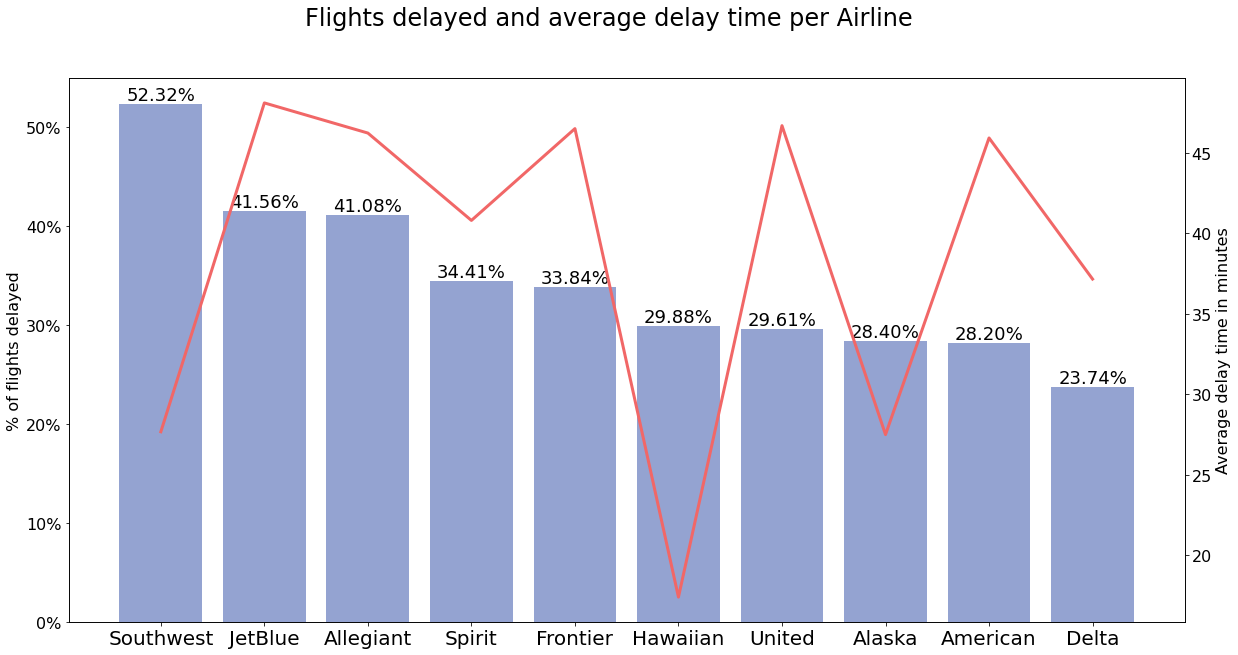

In [40]:
#Plotting bar and line chart for airlines

airline = list(df_marketing_airlines.index)
delayed_flights = df_marketing_airlines['delayed_percent'].values
average_delay_time = df_marketing_airlines['avg_delay_time'].values

fig_airline, ax_airline_bar = plt.subplots(figsize=(20, 10))
delay_rate_bar = ax_airline_bar.bar(airline,delayed_flights, color = colors[4])

ax_airline_bar.bar_label(delay_rate_bar, label_type='edge', fmt = '%.2f%%', fontsize = 18)
ax_airline_bar.set_ylabel('% of flights delayed', fontsize = 16)
ax_airline_bar.tick_params(axis='y', labelsize=16)
ax_airline_bar.tick_params(axis='x', labelsize=20)
ax_airline_bar.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))


ax_airline_line = ax_airline_bar.twinx()

delay_time_line = ax_airline_line.plot(airline, average_delay_time, color = colors[0], linewidth = 3)

ax_airline_line.set_ylabel('Average delay time in minutes', fontsize = 16)
ax_airline_line.tick_params(axis='y', labelsize=16)

fig_airline.suptitle('Flights delayed and average delay time per Airline', fontsize = 24)

plt.savefig("graphs/delays_airlines.png")
plt.show()

### 5. In which airports and cities is your flight most likely to be delayed/canceled due to weather conditions?

In [41]:

#get boolean for flights delayed due to eather conditions
df_flights['weather_delayed'] = [True if x > 0 else False for x in df_flights['weather_delay_time']]


#get weather delayed flights and delay time per airport
df_flight_airports = df_flights[['origin_airport', 'flights','delayed','weather_delay_time','weather_delayed']]
df_flight_airports = df_flight_airports.groupby(['origin_airport']).sum()

df_flight_airports['weather_delayed_percent'] = df_flight_airports['weather_delayed']/df_flight_airports['delayed']
df_flight_airports['avg_weather_delay_time'] = df_flight_airports['weather_delay_time']/df_flight_airports['delayed']

df_flight_airports.replace(np.nan,0, inplace=True)


In [42]:
df_geographical = df_flight_airports.join(df_airports)
df_geographical.head(5)

,flights,delayed,weather_delay_time,weather_delayed,weather_delayed_percent,avg_weather_delay_time,airport_name,city,state,country,latitude,longitude
ABE,5360.0,1242,4015.0,56,0.045089,3.232689,Lehigh Valley International,Allentown,PA,USA,40.652363,-75.440402
ABI,2389.0,486,6411.0,53,0.109053,13.191358,Abilene Regional,Abilene,TX,USA,32.411320,-99.681897
ABQ,17891.0,6067,10755.0,161,0.026537,1.772705,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194
ABR,750.0,166,2051.0,16,0.096386,12.355422,Aberdeen Regional,Aberdeen,SD,USA,45.449056,-98.421833
ABY,1046.0,110,258.0,7,0.063636,2.345455,Southwest Georgia Regional,Albany,GA,USA,31.535515,-84.194473


In [43]:
latitude = df_geographical['latitude'].values
longitude = df_geographical['longitude'].values
weather_delayed_percent = df_geographical['weather_delayed_percent'].values *100
avg_weather_delay_time = df_geographical['avg_weather_delay_time'].values


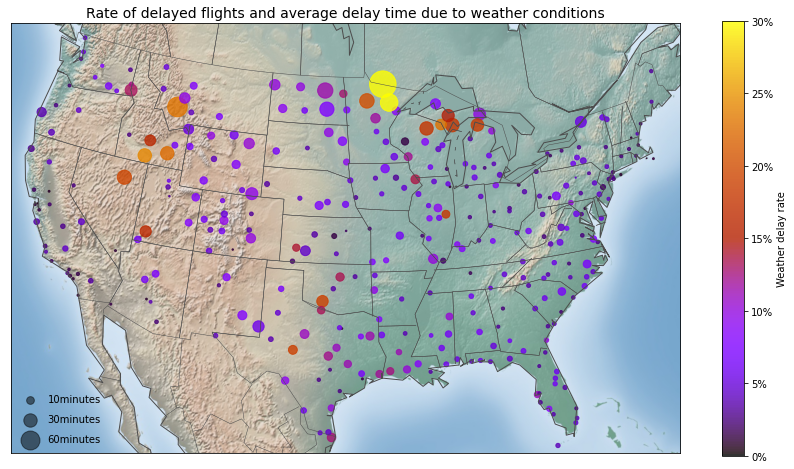

In [44]:
fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.shadedrelief()
m.drawcoastlines(color='#4d4d4d')
m.drawcountries(color='#4d4d4d')
m.drawstates(color='#4d4d4d')

m.scatter(longitude, latitude, latlon=True,
          c=weather_delayed_percent, s=avg_weather_delay_time*6,
          cmap='gnuplot', alpha = 0.8 , vmin = 0, vmax = 30)

plt.title('Rate of delayed flights and average delay time due to weather conditions', fontsize = 14 )
plt.colorbar(format = '%.f%%', label='Weather delay rate' )

for a in [10, 30, 60]:
    plt.scatter([], [], c='k', alpha=0.5, s=a*6,
                label=str(a) + 'minutes')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left')

plt.savefig("graphs/delays_map.png")
plt.show()